## Import

In [40]:
from sqlalchemy import create_engine, func, desc
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import pandas as pd
import matplotlib.pyplot as plt


## Use SQLAlchemy create_engine to connect to your sqlite database.

In [2]:
engine = create_engine('sqlite:///./Resources/hawaii.sqlite')

## Declare a Base using automap_base( )

In [3]:
Base = automap_base()

## Use teh Base classs to reflect the database tables

In [4]:
Base.prepare(engine, reflect=True)

## Use key( ) method to get the table information

In [5]:
Base.classes.keys()

['measurement', 'station']

## save a reference to those classes called Station and Measurement.

In [6]:
Station = Base.classes.station
Measurement = Base.classes.measurement

## Create a session

In [7]:
session = Session(engine)

## Display columns

In [8]:
session.query(Station).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fd050365c10>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0}

In [9]:
session.query(Measurement).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fd05037b250>,
 'tobs': 65.0,
 'id': 1,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'prcp': 0.08}

## Retrieve the last 12 months of precipitation data.
### ORM query solution

In [11]:
prcp_results = session.query(Measurement.date, Measurement.prcp)\
                 .filter(Measurement.date > '2016-08-23').all()
prcp_results[:10]

[('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0)]

### sql solution

In [12]:
sql_statement = "SELECT date, prcp FROM Measurement WHERE date > '2016-08-23';"
engine.execute(sql_statement).fetchall()[:10]


[('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0)]

### Load the query results into a Pandas DataFrame
### Set the index to the date column
### Sort the DataFrame values by date

In [22]:

prcp_df = pd.DataFrame([{"date": date , "prcp": prcp} for date, prcp in prcp_results])\
            .set_index("date")\
            .sort_index()

### Plot the results using the DataFrame plot method.

<BarContainer object of 2223 artists>

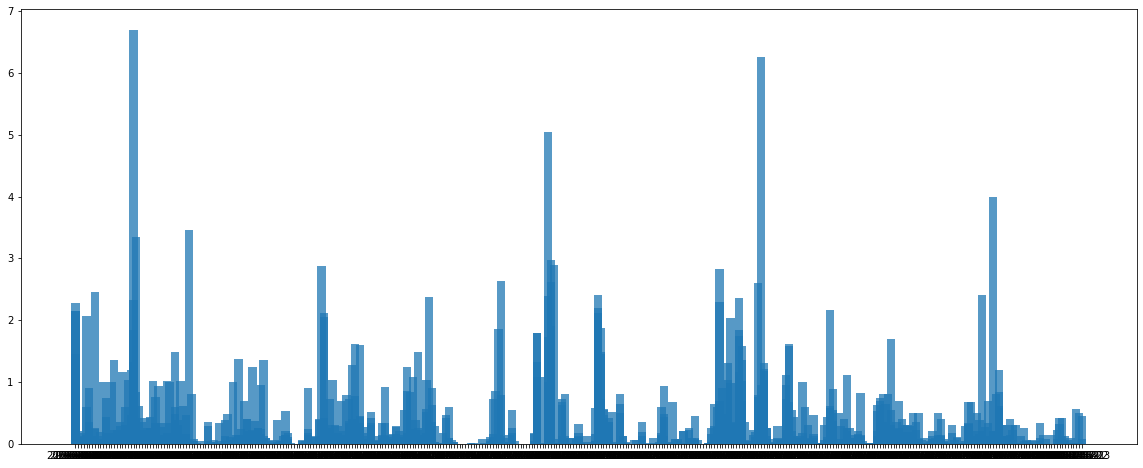

In [29]:
prcp_pf1 = prcp_df.dropna()
prcp_df2 = prcp_df.head(100)
plt.figure(figsize=(20,8))
x_axis = prcp_df.index.to_list()
plt.bar(x_axis, prcp_df["prcp"], width=3, alpha=0.75)
# plt.xlim('2016-08-23', '2017-08-23')

## Use Pandas to print the summary statistics for the precipitation data.

# Station Analysis

## Design a query to calculate the total number of stations.

In [32]:
session.query(Station.station).count()

9

## Design a query to find the most active stations.
- List the stations and observation counts in descending order.
- Which station has the highest number of observations?

In [41]:
session.query(Measurement.station, func.count(Measurement.prcp))\
            .group_by(Measurement.station)\
            .order_by(desc(func.count(Measurement.prcp)))\
            .all()

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

### The station 'USC00519281' has the highest number of observations

## Design a query to retrieve the last 12 months of temperature observation data (TOBS).
- Filter by the station with the highest number of observations.
- Plot the results as a histogram with bins=12.

In [53]:
# Get the station of hignest number of observations over the last 12 months
station_with_highest_observation, _ = session.query(Measurement.station, func.count(Measurement.tobs))\
                                                    .filter(Measurement.date > '2016-08-23')\
                                                    .group_by(Measurement.station)\
                                                    .order_by(desc(func.count(Measurement.tobs)))\
                                                    .all()[0]                    
station_with_highest_observation

'USC00519397'

In [57]:
temperatures = session.query(Measurement.tobs)\
                .filter(Measurement.station == station_with_highest_observation)\
                .all()
temperatures[:5]

[(65.0), (63.0), (74.0), (76.0), (73.0)]

(array([  7.,  17.,  40., 131., 124., 325., 485., 443., 883., 218.,  47.,
          4.]),
 array([56.        , 58.58333333, 61.16666667, 63.75      , 66.33333333,
        68.91666667, 71.5       , 74.08333333, 76.66666667, 79.25      ,
        81.83333333, 84.41666667, 87.        ]),
 <a list of 12 Patch objects>)

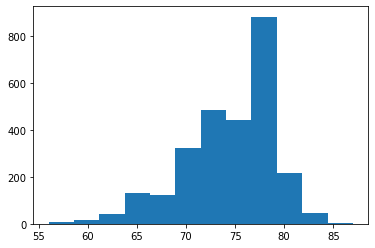

In [61]:
plt.hist([temp for temp, in temperatures], bins=12)


# Climte App

#### Use Pandas read_sql method

In [68]:
prcp_df1 = pd.read_sql("SELECT date, prcp FROM Measurement WHERE date > '2016-08-23';", engine)\
                        .sort_values(by="date")
prcp_df1

,date,prcp
0,2016-08-24,0.08
1006,2016-08-24,NaN
1524,2016-08-24,2.15
702,2016-08-24,2.28
360,2016-08-24,2.15
...,...,...
1522,2017-08-22,0.00
1523,2017-08-23,0.08
359,2017-08-23,0.00
1005,2017-08-23,0.00


In [63]:
results = session.query(Measurement.date, Measurement.tobs).all()
[{date: tobs} for date, tobs in results]

[{'2010-01-01': 65.0},
 {'2010-01-02': 63.0},
 {'2010-01-03': 74.0},
 {'2010-01-04': 76.0},
 {'2010-01-06': 73.0},
 {'2010-01-07': 70.0},
 {'2010-01-08': 64.0},
 {'2010-01-09': 68.0},
 {'2010-01-10': 73.0},
 {'2010-01-11': 64.0},
 {'2010-01-12': 61.0},
 {'2010-01-14': 66.0},
 {'2010-01-15': 65.0},
 {'2010-01-16': 68.0},
 {'2010-01-17': 64.0},
 {'2010-01-18': 72.0},
 {'2010-01-19': 66.0},
 {'2010-01-20': 66.0},
 {'2010-01-21': 69.0},
 {'2010-01-22': 67.0},
 {'2010-01-23': 67.0},
 {'2010-01-24': 71.0},
 {'2010-01-25': 67.0},
 {'2010-01-26': 76.0},
 {'2010-01-27': 68.0},
 {'2010-01-28': 72.0},
 {'2010-01-30': 70.0},
 {'2010-01-31': 67.0},
 {'2010-02-01': 66.0},
 {'2010-02-03': 67.0},
 {'2010-02-04': 69.0},
 {'2010-02-05': 67.0},
 {'2010-02-06': 67.0},
 {'2010-02-07': 64.0},
 {'2010-02-08': 69.0},
 {'2010-02-09': 73.0},
 {'2010-02-11': 73.0},
 {'2010-02-12': 69.0},
 {'2010-02-13': 69.0},
 {'2010-02-14': 69.0},
 {'2010-02-15': 71.0},
 {'2010-02-16': 61.0},
 {'2010-02-17': 69.0},
 {'2010-02-

In [67]:
session.query(Measurement.station, func.count(Measurement.tobs))\
                                                    .group_by(Measurement.station)\
                                                    .order_by(desc(func.count(Measurement.tobs)))\
                                                    .all()        

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [74]:
TMIN, TAVG, TMAX = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs))\
                .filter(Measurement.date >= '2016-12-23').filter(Measurement.date <= '2017-08-23').all()[0]
TMIN, TAVG, TMAX

(58.0, 74.05024088093599, 87.0)